In [ ]:
!pip install pettingzoo

import numpy as np
import gym
from gym import spaces
from gym.spaces import Discrete, Tuple, Dict
from collections import namedtuple

from pettingzoo import AECEnv

import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

import matplotlib.pyplot as plt
import random

from google.colab import drive
drive.mount('/gdrive')

%matplotlib inline
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 816.1/816.1 KB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 879.1/879.1 KB 38.9 MB/s eta 0:00:00
Mounted at /gdrive


# Environment Class


---


This is a custom-made environment class for the Game of Skull, that inherits the AECEnv from the PettingZoo library. It can take optional arguments in case the game should be ran from a specific stage onwards. Otherwise the default values will be used for initializing and reseting the class.

This implementation focuses on the two-player zero-sum variation of the game.



---

There are 12 possible actions that an agent can take:


1.   Play a skull card
2.   Play a rose card
3.   Raise a bet
4.   Pass a turn
5.   Flip the card at slot 0 in the player's own hand
6.   Flip the card at slot 1 in the player's own hand
7.   Flip the card at slot 2 in the player's own hand
8.   Flip the card at slot 3 in the player's own hand
9.   Flip the card at slot 0 in the opponent's hand
10.   Flip the card at slot 1 in the opponent's hand
11.   Flip the card at slot 2 in the opponent's hand
12.   Flip the card at slot 3 in the opponent's hand

If an action is not legal in the current phase of the game, it is labeled as an illegal action and subsequently penalized. 



In [ ]:
class GameOfSkullEnv(AECEnv):
  metadata = {
        "render_modes": ["human"],
        "name": "skull",
        "is_parallelizable": False,
        "render_fps": 1,
    }

  def __init__(self, agent_selection=None, observation_space=None):
    super().__init__()
    self._init(agent_selection, observation_space)

  def _init(self, agent_selection=None, observation_space=None):
    self.agents = ['agent0', 'agent1']
    self.num_roses = [3, 3]
    self.num_skulls = [1, 1]
    self.history_cards = 0
    self.action = None
    self.skulls = {"skull0": 1, "skull1": 1}
    self.passed = -1
    self.played = 0

    if agent_selection == None and observation_space==None:
      self.agent_selection = 0
      self.phase = 0
      self.current_bet = 0
      self.cards_to_flip = {}
      self.observation_space = {
      'agent0': [0, 0, 0, 0],
      'agent1': [0, 0, 0, 0],
      'current_bet': 0,
      'cards_to_flip': 0,
      'skull': 1,
      'phase': 0
      }
      
    else:
      self.observation_space = observation_space
      self.agent_selection = agent_selection
      self.cards_to_flip = list(self.observation_space['agent'+str(self._next_turn())]) + list(self.observation_space['agent' + str(self.agent_selection)])
      self.phase = self.observation_space['phase']
      self.current_bet = self.observation_space['current_bet']
      self.skulls['skull'+str(self.agent_selection)] = self.observation_space['skull']

    self.rewards = [0, 0]
    self.dones = {'agent0': False, 'agent1': False, "__all__": False}
    self.action_spaces = Tuple([Discrete(4), Discrete(8)])
    # actions - play_skull, play_rose, bet, pass, flip0, flip1, flip2, flip3, flip4, flip5, flip6, flip7
    self.observation = namedtuple("observation_space", "self0 self1 self2 self3 opp0 opp1 opp2 opp3 current_bet cards_to_flip skull phase") 
  
  def reset(self, agent_selection=None, observation_space=None):
    self._init(agent_selection, observation_space)
    return self.get_observation_space()

  def _int_to_name(self, ind):
    return self.agents[ind]

  def _name_to_int(self, name):
    return self.agents.index(name)

  def _next_turn(self):
    return abs(self.agent_selection-1)

  def step(self, action):
    info = {}
    agent = 'agent' + str(self.agent_selection)
    opponent = 'agent' + str(self._next_turn())
    self.get_phase()
  
    if self.phase == 0:
      if action == 0:
        self.play_skull()
        self.played += 1
        self.agent_selection = self._next_turn()
      elif action == 1:
        self.play_rose()
        self.played += 1
        self.agent_selection = self._next_turn()
      elif action == 2:
        if self.played >= 2:
          self.bet()
          self.agent_selection = self._next_turn()
        else:
          self.end_game_invalid_action()
      else:
        self.end_game_invalid_action()
  
    elif self.phase == 1:
      if action == 2:
        self.bet()
        self.phase = 2
        self.observation_space['phase'] = 2
        self.agent_selection = self._next_turn()
      elif action == 3 and self.passed == -1:
        self.pass_turn()
        self.agent_selection = self._next_turn()
      else:
        self.end_game_invalid_action()

    elif self.phase == 2:
      skull = 0
      if action <= 3:
        self.end_game_invalid_action()
      act = action-4
      if not self.flip(act):
        if self.agent_selection == 0:
          print("Agent 0 flipped a Skull")
          print("WINNER: Agent 1")
          print("LOSER: Agent 0")
          self.rewards[0] = -1
          self.rewards[1] = 1
        elif self.agent_selection == 1:
          print("Agent 1 flipped a Skull")
          print("WINNER: Agent 0")
          print("LOSER: Agent 1")
          self.rewards[1] = -1
          self.rewards[0] = 1
        skull = 1
        self.set_dones()
      if skull == 0 and self.observation_space['cards_to_flip'] == 0:
        if self.agent_selection == 1:
          print("Agent 1 did not flip a Skull")
          print("WINNER: Agent 1")
          print("LOSER: Agent 0")
          self.rewards[0] = -1
          self.rewards[1] = 1
        elif self.agent_selection == 0:
          print("Agent 0 did not flip a Skull")
          print("WINNER: Agent 0")
          print("LOSER: Agent 1")
          self.rewards[1] = -1
          self.rewards[0] = 1
        self.set_dones()
    self.get_phase()
    return self.get_observation_space(), self.rewards, self.dones, info

  
  def end_game_invalid_action(self):
    if self.agent_selection == 0:
      self.rewards[0] = -10
    elif self.agent_selection == 1:
      self.rewards[1] = -10
    self.set_dones()

  def set_dones(self):
    self.dones = {'agent0': True, 'agent0': True, '__all__': True}
  
  def is_done(self):
    if self.dones['__all__']:
      return 1
    else:
      return 0

  def get_observation_space(self):

    state = [self.observation_space['current_bet'],self.observation_space['cards_to_flip'], self.observation_space['skull'], self.observation_space['phase']]

    if self.agent_selection == 0:
      obs = self.observation(self.observation_space['agent0'][0], self.observation_space['agent0'][1], self.observation_space['agent0'][2], self.observation_space['agent0'][3],
                             self.observation_space['agent1'][0], self.observation_space['agent1'][1], self.observation_space['agent1'][2], self.observation_space['agent1'][3],
                             state[0], state[1], state[2], state[3])
    elif self.agent_selection == 1:
      obs = self.observation(self.observation_space['agent1'][0], self.observation_space['agent1'][1], self.observation_space['agent1'][2], self.observation_space['agent1'][3],
                             self.observation_space['agent0'][0], self.observation_space['agent0'][1], self.observation_space['agent0'][2], self.observation_space['agent0'][3], 
                             state[0], state[1], state[2], state[3])
    return obs

  def get_phase(self):
    if self.observation_space['current_bet'] > 0 and self.observation_space['cards_to_flip'] == 0:
      self.phase = 1
      self.observation_space['phase'] = 1
    elif self.observation_space['cards_to_flip'] > 0:
      self.phase = 2
      self.observation_space['phase'] = 2
    else:
      self.phase = 0

  def play_card(self, ind):
    if self.agent_selection == 0:
      cards = self.observation_space['agent0']
    elif self.agent_selection == 1:
      cards = self.observation_space['agent1']
    update_cards = list(cards)
    update_cards[ind] = 1
    self.history_cards += 1
    return update_cards

  def play_skull(self):
    if self.num_skulls[self.agent_selection] == 0:
      self.end_game_invalid_action()
    self.num_skulls[self.agent_selection] -=1
    if self.agent_selection == 0:
      old_cards = self.observation_space['agent0']
    elif self.agent_selection == 1:
      old_cards = self.observation_space['agent1']
    pos = -1
    for i in range(len(old_cards)):
      if old_cards[i] == 0:
        pos = i
        break
    if pos == -1:
      self.end_game_invalid_action()
      return
    else:
      cards = self.play_card(pos)
    if self.agent_selection == 0:
      self.observation_space['agent0'] = cards
    elif self.agent_selection == 1:
      self.observation_space['agent1'] = cards
    self.observation_space['skull'] = pos
    self.skulls['skull' + str(self.agent_selection)] = pos

  def play_rose(self):
    pos = 0
    if self.num_roses[self.agent_selection] == 0:
        self.end_game_invalid_action()
    if self.agent_selection == 0:
      self.num_roses[0] -=1
      for i in range(len(self.observation_space['agent0'])):
        if self.observation_space['agent0'][i] == 0:
          pos = i
      cards = self.play_card(pos)
      self.observation_space['agent0'] = cards
    elif self.agent_selection == 1:
      self.num_roses[1] -=1
      for i in range(len(self.observation_space['agent1'])):
        if self.observation_space['agent1'][i] == 0:
          pos = i
      cards = self.play_card(pos)
      self.observation_space['agent1'] = cards
  
  def bet(self):
    cnt_cards = 0
    for i in range(4):
      if self.observation_space['agent0'][i] == 1:
        cnt_cards += 1
      if self.observation_space['agent1'][i] == 1:
        cnt_cards += 1
    if self.observation_space['current_bet'] > 6 or self.observation_space['current_bet'] > cnt_cards:
      self.end_game_invalid_action()
    else:
      self.observation_space['current_bet'] += 1

  def pass_turn(self):
    self.passed = self.agent_selection
    self.observation_space['cards_to_flip'] = self.observation_space['current_bet']
    self.phase = 2
    self.observation_space['phase'] = 2
    self.cards_to_flip = list(self.observation_space['agent'+str(self._next_turn())]) + list(self.observation_space['agent' + str(self.agent_selection)])
    
  def flip(self, card):
    if (card < 4):
      if card == self.skulls['skull' + str(self.agent_selection)]:
        return 0
      self.observation_space['cards_to_flip'] -= 1
      self.cards_to_flip[card] = 0
      if self.agent_selection == 0:
        self.observation_space['agent0']= self.cards_to_flip[:4]
      elif self.agent_selection == 1:
        self.observation_space['agent1'] = self.cards_to_flip[:4]
    elif card >= 4:
      if card - 4 == self.skulls['skull' + str(self._next_turn())]:
        return 0 
      self.observation_space['cards_to_flip'] -= 1
      self.cards_to_flip[card] = 0
      if self.agent_selection == 0:
        self.observation_space['agent1'] = self.cards_to_flip[4:]
      elif self.agent_selection == 1:
        self.observation_space['agent0'] = self.cards_to_flip[4:]
    return 1

# Deep Q-Network Class
The DQN has 3 layers with the following states:


```
fc1.weight 	 torch.Size([256, 12])
fc1.bias 	 torch.Size([256])
fc2.weight 	 torch.Size([256, 256])
fc2.bias 	 torch.Size([256])
fc3.weight 	 torch.Size([12, 256])
fc3.bias 	 torch.Size([12])

```
As shown, the input is a one dimentional vector of size 12 and the output is again a vector indicating the best possible action out of the 12 that are available 

# Agent Class

The agent learns through the ɛ-greedy policy and with the experience replay technique(batch size is 64)



In [ ]:
class DeepQNetwork(nn.Module):
  def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
    super(DeepQNetwork, self).__init__()
    self.input_dims = input_dims
    self.fc1_dims = fc1_dims
    self.fc2_dims = fc2_dims
    self.n_actions = n_actions
    self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
    self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
    self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
    self.optimizer = optim.Adam(self.parameters(), lr=lr)
    self.loss = nn.MSELoss()
    self.device = T.device('cuda:0'if T.cuda.is_available() else 'cpu')
    self.to(self.device)

  def forward(self, state):
    x = F.relu(self.fc1(state.float()))
    x = F.relu(self.fc2(x))
    actions = self.fc3(x)

    return actions
     
class Agent():
  # eps_decay history = [5e-4, 0.00001, 0.000001]
  
  def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions, max_mem_size=100000, eps_end=0.01, eps_dec=0.00001):
    self.gamma = gamma
    self.epsilon = epsilon
    self.eps_min = eps_end
    self.eps_dec = eps_dec
    self.lr = lr
    self.action_space = [i for i in range(n_actions)]
    self.mem_size = max_mem_size
    self.batch_size = batch_size
    self.mem_cntr = 0

    self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, input_dims=input_dims, fc1_dims=256, fc2_dims=256)

    self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.int32)
    self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.int32)

    self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.reward_memory = np.zeros(self.mem_size, dtype=np.int32)
    self.terminal_memory = np.zeros(self.mem_size, dtype=bool)

  def reset_epsilon(self, eps):
    self.epsilon = eps

  def store_transition(self, state, action, reward, state_, done):
    index = self.mem_cntr % self.mem_size
    self.state_memory[index] = state
    self.new_state_memory[index] = state_
    self.reward_memory[index] = reward
    self.action_memory[index] = action
    self.terminal_memory[index] = done

    self.mem_cntr += 1

  def choose_action(self, observation):
    if np.random.random() > self.epsilon:
      state = T.tensor([observation]).to(self.Q_eval.device)
      actions = self.Q_eval.forward(state)
      action = T.argmax(actions).item()
    else:
      action = np.random.choice(self.action_space)
    
    return action
  
  def learn(self):
    if self.mem_cntr < self.batch_size:
      return

    self.Q_eval.optimizer.zero_grad()

    max_mem = min(self.mem_cntr, self.mem_size)
    batch = np.random.choice(max_mem, self.batch_size, replace=False)

    batch_index = np.arange(self.batch_size, dtype=np.int32)

    state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
    new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
    reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
    terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

    action_batch = self.action_memory[batch]
    q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
    q_next = self.Q_eval.forward(new_state_batch)
    q_next[terminal_batch] = 0.0

    q_target = reward_batch + self.gamma * T.max(q_next, dim=1)[0]
    
    loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
    loss.backward()
    self.Q_eval.optimizer.step()

    self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min else self.eps_min

## Load pretrained agents

This function is used to load the pretrained agents.


---


The code for training can be found in Experiment1_skull.ipynb, Experiment2_skull.ipynb,  Experiment3_skull.ipynb


---

The .pt files for the saved agents' can be found in the folder





In [ ]:
def load_models():
  agent0 = Agent(gamma=0.99, epsilon=0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)
  agent1 = Agent(gamma=0.99, epsilon=0, batch_size=64, n_actions=12, eps_end=0.01, input_dims=[12], lr=0.003)

  agent0.Q_eval = T.load('/content/drive/MyDrive/ColabNotebooks/BachelorProject/agent0_exp1_tr3_260_right.pt')


  agent1.Q_eval = T.load('/content/drive/MyDrive/ColabNotebooks/BachelorProject/agent1_exp1_tr3_260_right.pt')

  agent0.Q_eval.eval()
  agent1.Q_eval.eval()
  return (agent0, agent1)

In [ ]:
def plot_scores(agent0, agent1, games):
  plt.plot(games, agent0, label='Agent 0')
  plt.plot(games, agent1, label='Agent 1')
  plt.legend()
  plt.xlabel("Game")
  plt.ylabel("Score")
  plt.show()

1
observation_space(self0=0, self1=0, self2=0, self3=0, opp0=0, opp1=0, opp2=0, opp3=1, current_bet=0, cards_to_flip=0, skull=1, phase=0)
1
observation_space(self0=0, self1=0, self2=0, self3=1, opp0=0, opp1=0, opp2=0, opp3=1, current_bet=0, cards_to_flip=0, skull=1, phase=0)
1
observation_space(self0=0, self1=0, self2=0, self3=1, opp0=0, opp1=0, opp2=1, opp3=1, current_bet=0, cards_to_flip=0, skull=1, phase=0)
1
observation_space(self0=0, self1=0, self2=1, self3=1, opp0=0, opp1=0, opp2=1, opp3=1, current_bet=0, cards_to_flip=0, skull=1, phase=0)
1
observation_space(self0=0, self1=0, self2=1, self3=1, opp0=0, opp1=1, opp2=1, opp3=1, current_bet=0, cards_to_flip=0, skull=1, phase=0)
0
observation_space(self0=0, self1=1, self2=1, self3=1, opp0=1, opp1=0, opp2=1, opp3=1, current_bet=0, cards_to_flip=0, skull=0, phase=0)
2
observation_space(self0=1, self1=0, self2=1, self3=1, opp0=0, opp1=1, opp2=1, opp3=1, current_bet=1, cards_to_flip=0, skull=0, phase=1)
3
observation_space(self0=0, self1

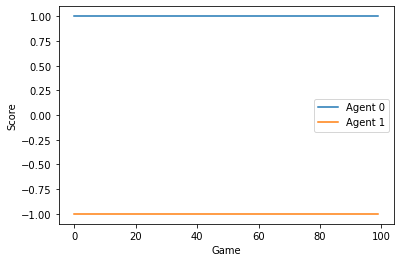

In [ ]:
if __name__ == '__main__':
  env = GameOfSkullEnv()
  scores = {'agent0': [], 'agent1': []}
  eps_history = {'agent0': [], 'agent1': []}
  n_games = 100
  agent0, agent1 = load_models()

  for i in range(n_games):
    # score0 = 0
    # score1 = 0
    done = False

    observation = env.reset()

    while not done:
      if env.agent_selection == 0:
        action = agent0.choose_action(observation)
        print(action)
        observation_, reward, dones, info = env.step(action)
        observation = observation_
        print(observation)
      else:
        action = agent1.choose_action(observation)
        print(action)
        observation_, reward, dones, info = env.step(action)
        observation = observation_
        print(observation)
      if env.is_done():
        score0 = reward[0]
        score1 = reward[1]
        done = True

    scores['agent0'].append(score0)
    scores['agent1'].append(score1)
    eps_history['agent0'].append(agent0.epsilon)
    eps_history['agent1'].append(agent1.epsilon)
    avg_score0 = np.mean(scores['agent0'][-100:])
    avg_score1 = np.mean(scores['agent1'][-100:])

    if score0 == 1 or score1 == 1 or score0 == -1 or score1 == -1:
      print('---------------End of the game---------------------')
    print('Game ', i, 'score0 %.2f' %score0, 'score1 %.2f' %score1, 
          'average score0 %.2f' % avg_score0, 'average score1 %.2f' % avg_score1)
    
  plot_scores(scores['agent0'], scores['agent1'], [i for i in range(n_games)])